In [1]:
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
from dolfinx.plot import vtk_mesh
import matplotlib.pyplot as plt
import gmsh

In [2]:
pyvista.start_xvfb()

In [3]:
gmsh.initialize()

In [4]:
gmsh.model.occ.addRectangle??

Signature: gmsh.model.occ.addRectangle(x, y, z, dx, dy, tag=-1, roundedRadius=0.0)
Source:   
        @staticmethod
        def addRectangle(x, y, z, dx, dy, tag=-1, roundedRadius=0.):
            """
            gmsh.model.occ.addRectangle(x, y, z, dx, dy, tag=-1, roundedRadius=0.)

            Add a rectangle in the OpenCASCADE CAD representation, with lower left
            corner at (`x', `y', `z') and upper right corner at (`x' + `dx', `y' +
            `dy', `z'). If `tag' is positive, set the tag explicitly; otherwise a new
            tag is selected automatically. Round the corners if `roundedRadius' is
            nonzero. Return the tag of the rectangle.

            Return an integer.

            Types:
            - `x': double
            - `y': double
            - `z': double
            - `dx': double
            - `dy': double
            - `tag': integer
            - `roundedRadius': double
            """
            ierr = c_int()
            api_result_ = lib.gm

In [5]:
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

1

In [6]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000135285s, CPU 0.000405s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0462262s, CPU 0.047632s)
Info    : 1550 nodes 3099 elements


In [7]:
from dolfinx.io import gmshio
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
V = fem.functionspace(domain, ("Lagrange", 1))

In [8]:
fem.FunctionSpace??

Init signature:
fem.FunctionSpace(
    mesh: 'Mesh',
    element: 'ufl.FiniteElementBase',
    cppV: 'typing.Union[_cpp.fem.FunctionSpace_float32, _cpp.fem.FunctionSpace_float64]',
)
Source:        
class FunctionSpace(ufl.FunctionSpace):
    """A space on which Functions (fields) can be defined."""

    _cpp_object: typing.Union[_cpp.fem.FunctionSpace_float32, _cpp.fem.FunctionSpace_float64]
    _mesh: Mesh

    def __init__(
        self,
        mesh: Mesh,
        element: ufl.FiniteElementBase,
        cppV: typing.Union[_cpp.fem.FunctionSpace_float32, _cpp.fem.FunctionSpace_float64],
    ):
        """Create a finite element function space.

        Note:
            This initialiser is for internal use and not normally called
            in user code. Use :func:`functionspace` to create a function space.

        Args:
            mesh: Mesh that space is defined on
            element: UFL finite element
            cppV: Compiled C++ function space.

        """
        if mes

In [9]:
V

FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))

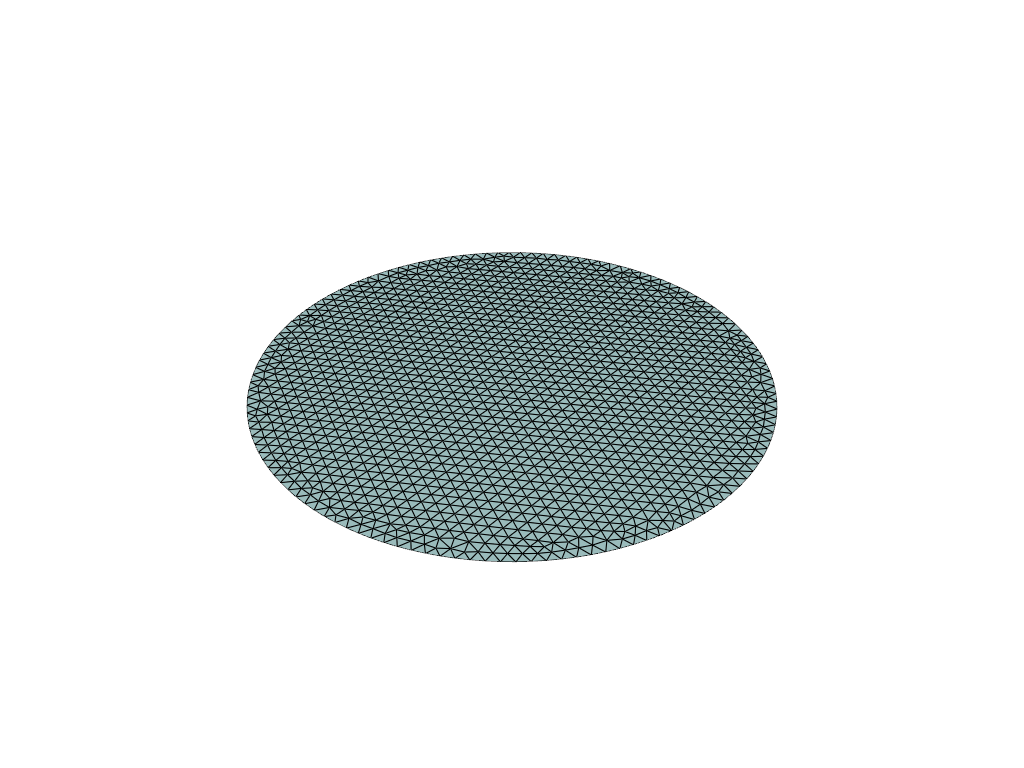

In [10]:
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

p.add_mesh(grid, show_edges=True)
p.show()

**For BOX mesh using gmsh** <br>
*Comment out this stuff and change cell to code type* <br>

from dolfinx.io import gmshio
box=gmsh.model.occ.addBox(0,0,0,1,1,1)
gmsh.model.occ.synchronize()
gdim1 = 3
gmsh.model.addPhysicalGroup(gdim1, [box], 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim1)
gmsh_model_rank1 = 0
mesh_comm1 = MPI.COMM_WORLD
domain1, cell_markers1, facet_markers1 = gmshio.model_to_mesh(gmsh.model, mesh_comm1, gmsh_model_rank1, gdim=gdim1)
V1 = fem.FunctionSpace(domain1, ("Lagrange", 1))
p1 = pyvista.Plotter()
topology1, cell_types1, geometry1 = plot.vtk_mesh(V1)
grid1 = pyvista.UnstructuredGrid(topology1, cell_types1, geometry1)

p1.add_mesh(grid1, show_edges=True)
p1.show()

In [11]:
x = ufl.SpatialCoordinate(domain)
beta = fem.Constant(domain, default_scalar_type(8))
R0 = fem.Constant(domain, default_scalar_type(0.6))
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))
x, beta, R0, p

(SpatialCoordinate(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0)),
 Constant(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), (), 0),
 Constant(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), (), 1),
 Product(IntValue(4), Exp(Product(Sum(Power(Indexed(SpatialCoordinate(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0)), MultiIndex((FixedIndex(0),))), IntValue(2)), Power(Sum(Indexed(SpatialCoordinate(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0)), MultiIndex((FixedIndex(1),))), Product(IntValue(-1), Constant(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), (), 1))), IntValue(2))), Product(IntValue(-1), Power(Constant(Mesh(blocked element (Basix element (P, tri

In [12]:
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)
bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

In [13]:
#def clamped_boundary(x):
#    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)


#fdim = domain.topology.dim - 1
#boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

#u_D = default_scalar_type(0)
#bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [14]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = p * v * ufl.dx
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [15]:
uh

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 0)

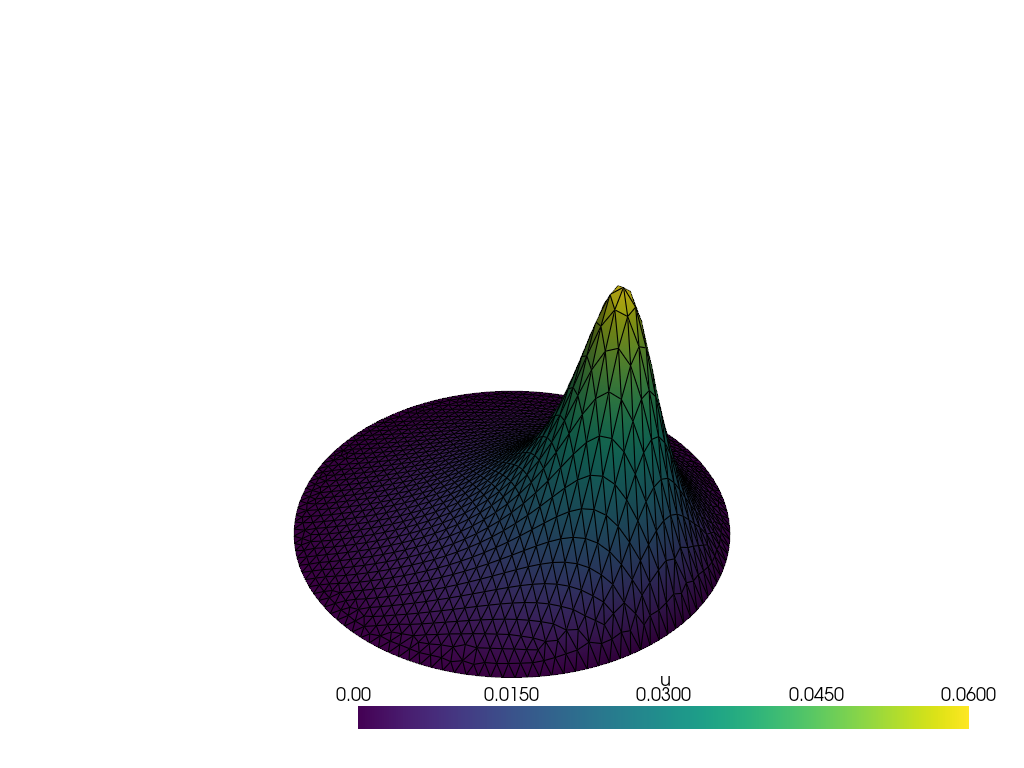

In [16]:

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)

plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
plotter.show()

In [17]:
Q = fem.functionspace(domain, ("Lagrange", 5))
expr = fem.Expression(p, Q.element.interpolation_points())
pressure = fem.Function(Q)
pressure.interpolate(expr)

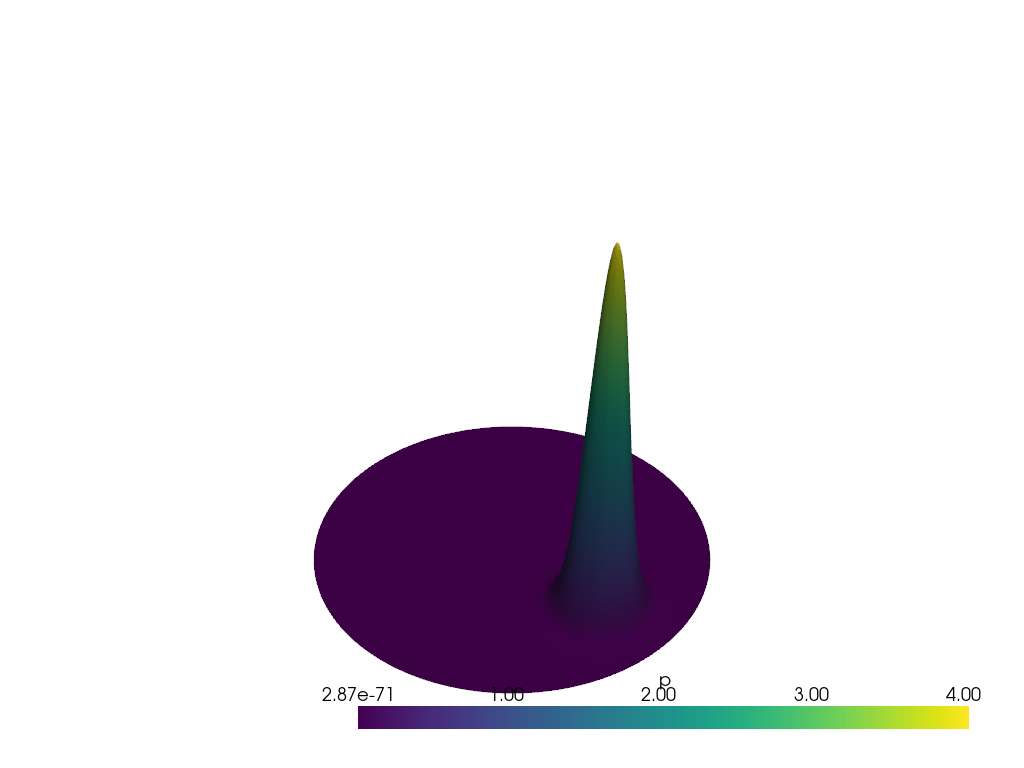

In [18]:
load_plotter = pyvista.Plotter()
p_grid = pyvista.UnstructuredGrid(*vtk_mesh(Q))
p_grid.point_data["p"] = pressure.x.array.real
warped_p = p_grid.warp_by_scalar("p", factor=0.5)
warped_p.set_active_scalars("p")
load_plotter.add_mesh(warped_p, show_edges=False, show_scalar_bar=True)
load_plotter.show()

In [19]:
from dolfinx import geometry
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []
p_values = []
bb_tree = geometry.bb_tree(domain, domain.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

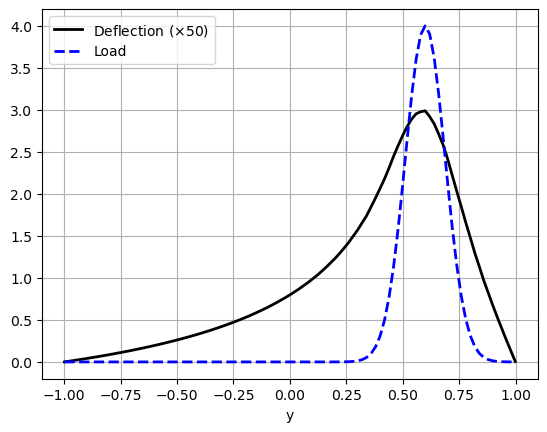

In [20]:
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = pressure.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 1], 50 * u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")